In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torchview import draw_graph
import graphviz

In [2]:
# Загрузка данных
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=testtransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('Размерность тренировочных входных данных: {}'.format(trainset.data.shape))
print('Размерность тестовых входных данных: {}'.format(testset.data.shape))
print('Размерность ответов для тренировочных входных данных: {}'.format(len(trainset.targets)))
print('Размерность ответов для тестовых входных данных: {}'.format(len(testset.targets)))
print('Размер одного изображения: {}x{}'.format(trainset[0][0].shape[1], trainset[0][0].shape[2]))


Размерность тренировочных входных данных: (50000, 32, 32, 3)
Размерность тестовых входных данных: (10000, 32, 32, 3)
Размерность ответов для тренировочных входных данных: 50000
Размерность ответов для тестовых входных данных: 10000
Размер одного изображения: 32x32


In [4]:
def show_imgs(batch_size, dload):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    f, ax = plt.subplots(int(batch_size / 4), 4, figsize = (12, 12))
    ax = ax.flatten()
    
    # Получение случайного образца из тренировочного датасета
    dataiter = iter(dload)
    images, labels = next(dataiter)
    # Вывод отдельных изображений и их меток классов
    j = 0
    for a in ax:
        images[j] = images[j] / 2 + 0.5  # Денормализация
        npimg = images[j].numpy()
        a.imshow(np.transpose(npimg, (1, 2, 0)))
        a.set_title(classes[labels[j]])
        j+=1
    
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=4.0, wspace=None, hspace=None)
    plt.show()


### Тренировочные данные

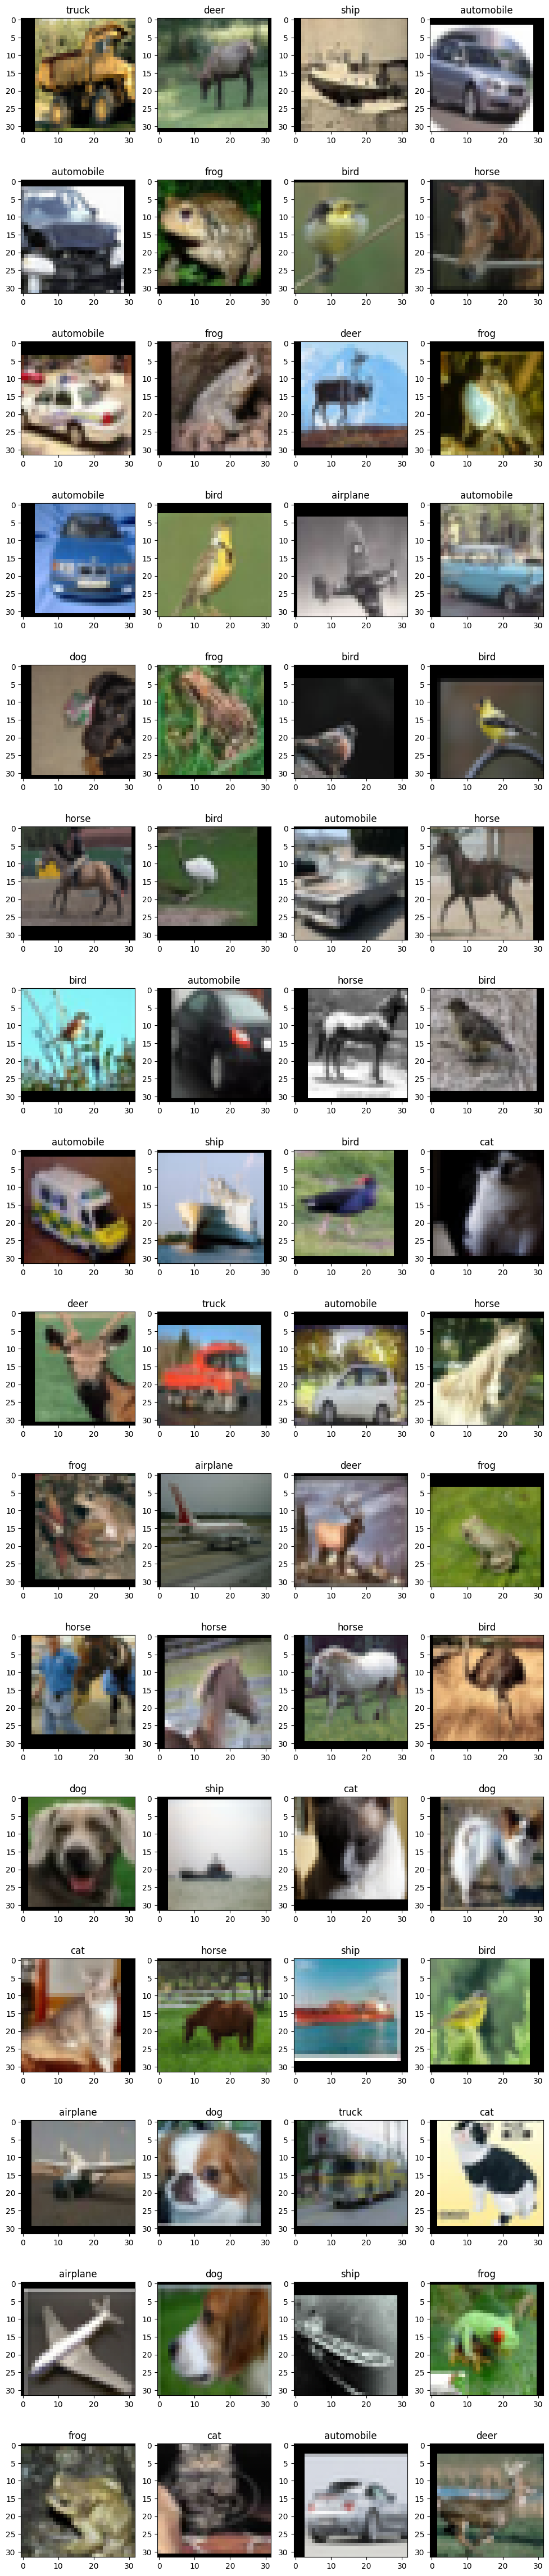

In [5]:
show_imgs(batch_size / 2, trainloader)

### Тестовые данные

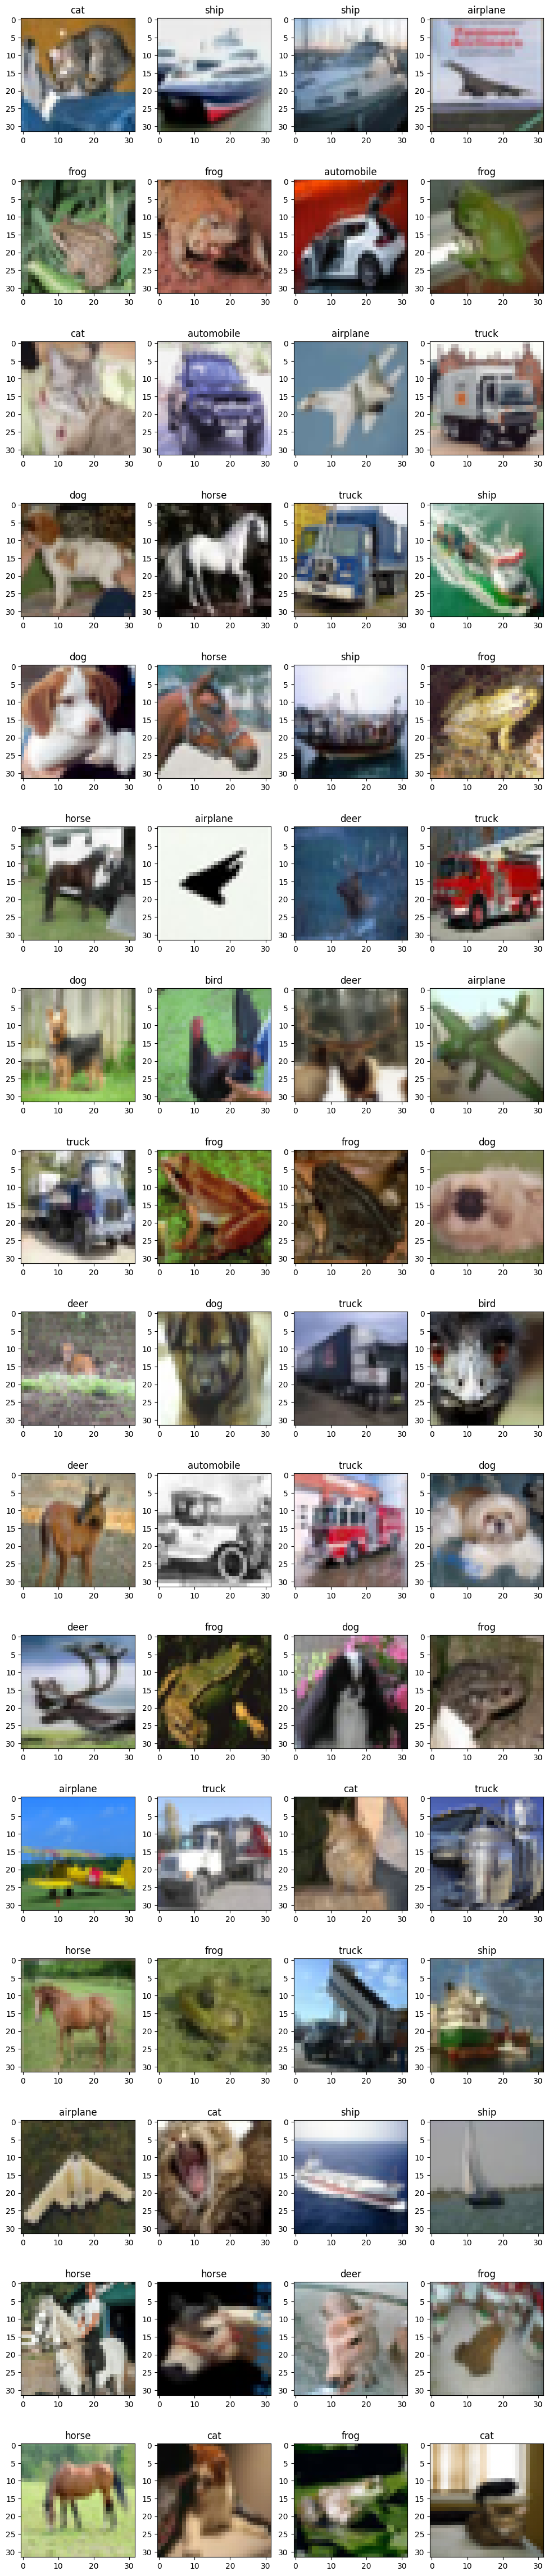

In [6]:
show_imgs(batch_size / 2, testloader)

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU()
        )
    def forward(self, x):
        out = self.block(x)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer2 = nn.Sequential(block(64, 128, 1))#, nn.MaxPool2d(2))
        self.max_pool1 = nn.MaxPool2d(2)

        self.layer3 = nn.Sequential(block(128, 256, 1))#, nn.MaxPool2d(2))
        self.max_pool2 = nn.MaxPool2d(2)
        
        self.layer4 = nn.Sequential(block(256, 256, 1), block(256, 256, 1))

        self.layer5 = nn.Sequential(block(256, 512, 1))#, nn.MaxPool2d(2))
        self.max_pool3 = nn.MaxPool2d(2)

        self.layer6 = nn.Sequential(block(512, 512, 1), block(512, 512, 1))

        self.max_pool4 = nn.MaxPool2d(4)

        #self.linear = nn.Linear(512, num_classes)

        self.lin = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.max_pool1(out)
        out = self.layer3(out)
        out = self.max_pool2(out)
        out1 = self.layer4(out)
        out = out1 + out
        out = self.layer5(out)
        out = self.max_pool3(out)
        out2 = self.layer6(out)
        out = out2 + out
        out = self.max_pool4(out)
        out = self.lin(out)
        return out

In [8]:
def get_accuracy(data_loader, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()#.item()
    return correct / total

# Обучение модели
def train(net, trainloader, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    for epoch in range(num_epochs):
        start_t = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        end_t = time.time()
        print('Epoch[{}]: accuracy = {}, Loss = {}, time = {}'.format(epoch,
            get_accuracy(trainloader, net), running_loss / len(trainloader), end_t - start_t))


In [9]:
# Определение модели, функции потерь и оптимизатора
net = ResNet(BasicBlock)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): BasicBloc


(dot.exe:6780): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


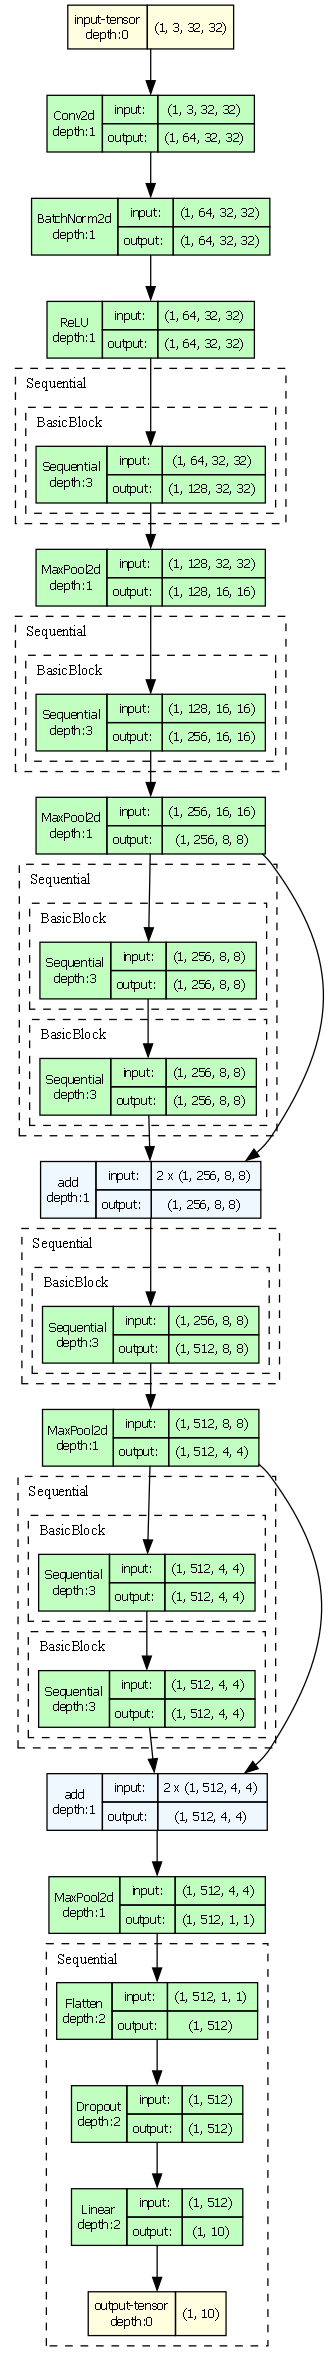

In [10]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(net, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [11]:
# Обучение модели
train(net, trainloader, criterion, optimizer, num_epochs=18)

# Тестирование модели
get_accuracy(testloader, net)

Epoch[0]: accuracy = 0.5776999592781067, Loss = 1.4321819438653833, time = 217.94000124931335
Epoch[1]: accuracy = 0.602400004863739, Loss = 1.5743130780851748, time = 220.0521104335785
Epoch[2]: accuracy = 0.7240999937057495, Loss = 0.9659317318740708, time = 217.51846551895142
Epoch[3]: accuracy = 0.7447999715805054, Loss = 0.7510804049194316, time = 220.45982193946838
Epoch[4]: accuracy = 0.7967999577522278, Loss = 0.635572668460324, time = 225.01217937469482
Epoch[5]: accuracy = 0.8166999816894531, Loss = 0.5558700313805924, time = 225.70323204994202
Epoch[6]: accuracy = 0.8252999782562256, Loss = 0.5085188499878129, time = 220.77813816070557
Epoch[7]: accuracy = 0.8377999663352966, Loss = 0.4553587386370315, time = 221.27502632141113
Epoch[8]: accuracy = 0.8443999886512756, Loss = 0.42434083683716367, time = 217.52286887168884
Epoch[9]: accuracy = 0.8499999642372131, Loss = 0.38533859465585646, time = 222.98191928863525
Epoch[10]: accuracy = 0.8504999876022339, Loss = 0.3545022111

tensor(0.8631, device='cuda:0')

In [12]:
torch.save(net.state_dict(), 'modelcopy.pth')

In [13]:
#loadmodel = Net()
loadmodel = ResNet(BasicBlock)
loadmodel.load_state_dict(torch.load('modelcopy.pth'))

<All keys matched successfully>

In [14]:
# Тестирование модели
print('Точность сети на тестовых изображениях: {}'.format(
    get_accuracy(testloader, loadmodel)))

Точность сети на тестовых изображениях: 0.863099992275238
